# Initialising and Imports

In [1]:
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.style.use('fivethirtyeight')
sea.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import os
import gc
import time
import copy
import shutil
import torch
import torch.nn as nn
import model_utils as u
import model_classes as c
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import utils, transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

# Setup device and Seed

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')

In [8]:
# https://pytorch.org/docs/stable/notes/randomness.html
seed = 325
u.set_all_seeds(seed)



---

---

---



# Setup Dataframe

Helper links:

https://stackoverflow.com/questions/16396903/delete-the-first-three-rows-of-a-dataframe-in-pandas<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html<br>
https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.insert.html<br>
https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html

In [9]:
# setup path to the dataset directory

PATH = "D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/"

In [10]:
# load dataset t0 dataframes: {"LUAD":Lung Adenocarcinoma, "LUSU":Lung Squamous Cell Carcinoma}
# https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe
# https://www.analyticsvidhya.com/blog/2021/04/delimiters-in-pandas-read_csv-function/

df_luad = pd.read_csv(PATH+"TCGA.LUAD.sampleMap_HiSeqV2_PANCAN.gz", compression = "gzip", sep = "\t")
df_lusu = pd.read_csv(PATH+"TCGA.LUSC.sampleMap_HiSeqV2_PANCAN.gz", compression = "gzip", sep = "\t")

In [11]:
df_luad

,sample,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
0,ARHGEF10L,0.125808,0.561708,-0.237592,-1.180492,-0.656192,0.139908,-0.537692,-0.839092,0.677108,...,0.226508,-2.342092,-0.207692,-0.659792,-1.651292,-2.621192,-1.025192,0.070108,0.305608,0.263208
1,HIF3A,-1.294926,6.069174,3.581474,3.927674,-0.525926,-1.497426,-0.021226,0.179974,1.092974,...,2.539674,-1.259526,-0.387226,3.689474,3.509374,1.986874,-1.993426,2.790974,-0.018326,4.657474
2,RNF17,-0.112935,-0.531035,0.592065,0.291065,-0.531035,0.475865,0.071065,-0.531035,-0.531035,...,-0.068235,-0.531035,0.428265,0.202865,0.567665,0.408165,-0.531035,0.440465,-0.531035,0.049365
3,RNF10,-1.411872,-0.228672,-0.108372,-0.043472,-0.156672,-0.605472,0.139328,-0.450172,0.583528,...,-0.451572,0.261228,-0.331772,-0.213372,-0.189472,0.091028,0.492828,0.037428,0.003728,-0.334572
4,RNF11,0.203922,0.052122,-0.499978,0.710822,0.373522,0.129022,0.436522,0.529622,0.314922,...,-0.155778,0.362522,-0.520578,0.031222,-0.966478,0.318322,0.150822,-0.357778,-0.451578,0.156422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20525,PTRF,0.863614,0.317114,-1.243086,2.802714,1.110714,0.879814,-0.028286,0.008714,-0.005186,...,0.544614,1.638214,0.381814,-1.080186,-2.139886,-1.495486,0.472314,0.993014,0.634014,1.222714
20526,BCL6B,0.802173,1.079073,-1.283227,2.250473,1.513973,0.126473,0.576073,0.643573,-0.735227,...,0.842873,0.680873,0.642773,0.154673,-0.849427,-0.359227,0.332973,0.570873,-0.909527,0.671573
20527,GSTK1,0.108205,-0.782695,0.034105,-0.540795,-0.454095,-0.797795,0.531305,0.310605,0.204105,...,-0.454195,-0.466595,-0.011995,-0.503195,0.512405,-0.584495,-1.756895,0.506805,-0.114895,-0.189095
20528,SELP,0.595367,3.114267,0.571467,3.985967,2.893167,1.805567,2.445467,2.575967,1.336567,...,2.817667,-0.301333,2.508367,-0.518033,-1.540033,1.663867,-0.275933,-0.073933,0.848867,1.195667


In [12]:
df_lusu

,sample,TCGA-18-3417-01,TCGA-22-4613-01,TCGA-90-7769-01,TCGA-77-A5G1-01,TCGA-77-A5G3-01,TCGA-66-2766-01,TCGA-37-4135-01,TCGA-56-8201-01,TCGA-56-7582-11,...,TCGA-77-8144-01,TCGA-J1-A4AH-01,TCGA-56-7580-01,TCGA-63-A5MY-01,TCGA-33-AASL-01,TCGA-85-A512-01,TCGA-85-8354-01,TCGA-O2-A5IB-01,TCGA-77-7335-01,TCGA-56-7731-11
0,ARHGEF10L,-2.032992,-1.109192,-1.270392,0.054708,-1.344192,-1.145092,-0.737892,-0.619892,-0.050992,...,-2.237692,-1.395092,-1.926792,-1.335292,-0.762292,-1.286992,-1.847792,0.568508,-0.849892,-0.888992
1,HIF3A,-0.775126,-1.023426,-3.254826,0.075174,0.826174,1.306874,-2.036826,-0.015326,2.772874,...,-5.006326,3.974574,3.154774,4.021874,-0.831926,-1.863426,-1.297326,0.025974,-2.414126,4.229474
2,RNF17,0.573765,-0.531035,-0.090835,-0.531035,-0.531035,-0.049535,0.829765,-0.531035,3.204265,...,-0.531035,1.349965,4.157765,1.554065,0.984465,-0.531035,-0.531035,0.084865,0.192865,-0.531035
3,RNF10,0.365228,-0.326772,0.160728,-0.147472,-0.364672,-0.697672,-0.765472,0.068428,-0.010572,...,-0.381072,-0.527472,0.171028,-0.292972,-0.651572,0.020328,-0.280072,-0.009372,0.197228,0.162228
4,RNF11,0.364522,0.308122,0.368322,0.826222,-0.312978,-0.792078,0.583822,-0.573278,0.323522,...,0.075622,-0.513978,-0.604678,0.479122,-0.446678,-0.560978,-0.560278,-0.136278,0.443922,0.344522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20525,PTRF,1.025014,-0.396686,0.094714,1.569614,1.269914,-0.263486,-2.675286,1.638114,2.118814,...,1.972214,0.993014,-0.233586,-0.222586,0.774714,0.434414,1.246914,-2.425586,1.550114,2.468514
20526,BCL6B,-0.381027,-0.781327,-2.267827,-0.409227,-0.542127,-0.932927,-1.847227,0.972273,4.176973,...,-0.010327,-1.413827,-0.132027,-1.714727,-2.306727,-0.491427,-0.070027,-0.734427,0.294773,2.667973
20527,GSTK1,0.839305,-0.732495,-1.137095,-0.003395,-1.324995,-0.113095,0.841305,-0.320395,-0.376795,...,-1.539295,-1.318095,-0.900095,0.251605,0.406205,0.318305,-0.620695,-1.926795,0.369005,-0.264695
20528,SELP,-1.085033,1.733867,-1.210233,1.761467,-1.784433,-0.762733,-2.145733,0.812667,1.800567,...,-3.797533,0.044667,-1.761533,-0.018533,-2.346733,-1.011433,-1.390333,-2.121633,1.909267,3.930867


# Dataset preprocessing 

In [13]:
df, labels, columns = u.dataset_preprocess(df_luad, df_lusu)

,label,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-69-7978-01,1,0.125808,-1.29493,-0.112935,-1.41187,0.203922,0.0993901,-0.222094,0.504354,-0.423399,...,1.13472,-0.845117,1.76017,-1.28139,0.224623,0.863614,0.802173,0.108205,0.595367,-0.222712
TCGA-62-8399-01,1,0.561708,6.06917,-0.531035,-0.228672,0.0521219,-1.20601,-0.338894,1.44985,0.0394006,...,-0.286078,-0.055517,-0.0282335,0.0480102,0.295223,0.317114,1.07907,-0.782695,3.11427,-0.388912
TCGA-78-7539-01,1,-0.237592,3.58147,0.592065,-0.108372,-0.499978,-0.0254099,0.163006,0.131654,-0.0508994,...,2.20992,-1.58712,1.56537,2.63871,0.0491232,-1.24309,-1.28323,0.0341054,0.571467,0.233588
TCGA-50-5931-11,1,-1.18049,3.92767,0.291065,-0.043472,0.710822,1.05089,-0.564394,1.68395,0.398701,...,-0.748878,0.900483,1.90357,-1.28139,-0.549277,2.80271,2.25047,-0.540795,3.98597,0.370988
TCGA-73-4658-01,1,-0.656192,-0.525926,-0.531035,-0.156672,0.373522,0.44729,-0.438994,1.83155,-0.423399,...,-0.748878,-0.931417,1.91517,-0.17659,0.0423232,1.11071,1.51397,-0.454095,2.89317,0.193788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-85-A512-01,0,-1.28699,-1.86343,-0.531035,0.020328,-0.560978,0.51729,0.519806,-0.748146,-0.423399,...,-0.748878,-1.58712,-0.236033,1.41071,1.65372,0.434414,-0.491427,0.318305,-1.01143,0.392288
TCGA-85-8354-01,0,-1.84779,-1.29733,-0.531035,-0.280072,-0.560278,0.85009,-0.166294,-1.51925,0.602101,...,0.276622,-1.58712,-0.784133,1.46201,0.765023,1.24691,-0.0700266,-0.620695,-1.39033,0.918888
TCGA-O2-A5IB-01,0,0.568508,0.0259737,0.084865,-0.00937199,-0.136278,-1.41811,0.173506,-2.19405,0.622701,...,-0.408378,-1.24662,-1.94053,-1.28139,1.28172,-2.42559,-0.734427,-1.92679,-2.12163,-0.637412
TCGA-77-7335-01,0,-0.849892,-2.41413,0.192865,0.197228,0.443922,0.54789,0.0844055,1.01505,-0.423399,...,-0.748878,-1.58712,2.16037,1.19391,0.197023,1.55011,0.294773,0.369005,1.90927,0.117688


In [14]:
# df_random_picked_genes = df.iloc[:, ls_random_genes_150]
# plt.figure(figsize=(20,10))
# sea.boxplot(data=df_random_picked_genes)
# plt.xlabel('Features (Genes)', fontsize='xx-large')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# # plt.yticks([-10, -5, 0, 5, 10, 15, 20], fontsize='xx-large')
# plt.title('Boxplot of 150 randomly picked features in primary dataset', fontsize='xx-large')
# plt.savefig(PATH+"dataframe_unprocessed_boxplot_sea", dpi=100, bbox_inches='tight')
# plt.show()

In [15]:
# plt.figure(figsize=(20,10))
# plt.boxplot(x=temp_df, showfliers=False)
# plt.xlabel('Features (Genes)', fontsize='xx-large')
# plt.xticks(fontsize='xx-large')
# plt.yticks([-10, -5, 0, 5, 10, 15, 20], fontsize='xx-large')
# plt.title('Boxplot of feature values of primary dataset', fontsize='xx-large')
# plt.savefig(PATH+"dataframe_unprocessed_boxplot", dpi=300, bbox_inches='tight')
# plt.show()

In [16]:
# ## compute outliers for each column


# Q1 = np.percentile(df, 25) 
# Q2 = np.percentile(df, 50) 
# Q3 = np.percentile(df, 75) 
  
# print('Q1 25 percentile of the given data is, ', Q1)
# print('Q1 50 percentile of the given data is, ', Q2)
# print('Q1 75 percentile of the given data is, ', Q3)
  
# IQR = Q3 - Q1 
# print('Interquartile range is', IQR)

In [17]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [18]:
# ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any()

# Train_Test_Split

In [19]:
df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df, labels, train_size=0.9, random_state=seed, stratify=labels)

In [20]:
df = df_xtrain.copy(deep=True)
labels = df_ytrain
df.reset_index(inplace=True, drop=True)
df_xtest.reset_index(inplace=True, drop=True)

# Dataset standardisation

In [21]:
# create StandardScaler object and normalise the dataset

scaler_df = StandardScaler()

In [22]:
# scale/normalise and transform the both xtraina and xtest using StandardScaler. 
# Note that this will convert the dataframes to np.ndarray, and that is what we want

df_scaled = scaler_df.fit_transform(df)

In [23]:
df_scaled

array([[ 0.60194351, -0.51260303,  0.16783496, ...,  1.0775639 ,
         0.37239114,  0.20205473],
       [-1.63751552, -1.66562737, -0.76943149, ..., -1.20409613,
        -0.11554825,  0.31835016],
       [-1.13516482,  1.01585638,  0.19219028, ..., -0.63017313,
        -1.97439867, -0.94626889],
       ...,
       [ 1.15899041,  1.03072796, -0.08858526, ...,  1.35928268,
         0.8652834 ,  0.20261745],
       [-0.1418535 , -1.46463312,  1.18349798, ..., -0.3998021 ,
         0.328795  ,  1.47023767],
       [-1.41849346, -1.59425204, -0.76943149, ..., -0.40828296,
        -2.00014271,  0.77659169]])

---

---



---



# Hyperparameters, Datasets and DataLoaders


1. Create and assign values to each hyperparameters
2. Create train_dataset object of LUNG_GeneExp class
3. Create train_dataloader for train_dataset 
4. Iterate through one sample of item from train_dataset and see if everything is working fine.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [24]:
input_dim = df.shape[1]
epochs = 150
batch_size = 64
learning_rate = 1e-4
output_dim = 512

In [25]:
train_dataset = c.LUNG_GeneExp(labels, df_scaled)

In [26]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

# Training and Plotting

1. Train autoencoder
2. Plot loss graph

In [27]:
u.set_all_seeds(seed)
model = c.AutoEncoder(input_dim, output_dim)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.001, amsgrad=False)

In [28]:
log_dict = u.train_encoder(
    num_epochs = epochs,
    model = model,
    optimizer = optimizer,
    device = device,
    train_loader = train_loader,
    skip_epoch_stats = False,
    logging_interval = 500
)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 001/150 | Batch 0000/0016 | Loss: 1.1733


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 002/150 | Batch 0000/0016 | Loss: 0.6708


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 003/150 | Batch 0000/0016 | Loss: 0.6128


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 004/150 | Batch 0000/0016 | Loss: 0.5777


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 005/150 | Batch 0000/0016 | Loss: 0.5574


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 006/150 | Batch 0000/0016 | Loss: 0.7460


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 007/150 | Batch 0000/0016 | Loss: 0.4815


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 008/150 | Batch 0000/0016 | Loss: 0.5898


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 009/150 | Batch 0000/0016 | Loss: 0.6108


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 010/150 | Batch 0000/0016 | Loss: 0.4079


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 011/150 | Batch 0000/0016 | Loss: 0.4072


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 012/150 | Batch 0000/0016 | Loss: 0.4583


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 013/150 | Batch 0000/0016 | Loss: 0.3876


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 014/150 | Batch 0000/0016 | Loss: 0.3977


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 015/150 | Batch 0000/0016 | Loss: 0.3512


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 016/150 | Batch 0000/0016 | Loss: 0.3597


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 017/150 | Batch 0000/0016 | Loss: 0.3582


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 018/150 | Batch 0000/0016 | Loss: 0.3436


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 019/150 | Batch 0000/0016 | Loss: 0.3237


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 020/150 | Batch 0000/0016 | Loss: 0.3125


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 021/150 | Batch 0000/0016 | Loss: 0.3193


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 022/150 | Batch 0000/0016 | Loss: 0.2878


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 023/150 | Batch 0000/0016 | Loss: 0.3334


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 024/150 | Batch 0000/0016 | Loss: 0.2759


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 025/150 | Batch 0000/0016 | Loss: 0.2696


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 026/150 | Batch 0000/0016 | Loss: 0.2540


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 027/150 | Batch 0000/0016 | Loss: 0.2711


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 028/150 | Batch 0000/0016 | Loss: 0.2569


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 029/150 | Batch 0000/0016 | Loss: 0.2468


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 030/150 | Batch 0000/0016 | Loss: 0.2402


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 031/150 | Batch 0000/0016 | Loss: 0.2550


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 032/150 | Batch 0000/0016 | Loss: 0.2715


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 033/150 | Batch 0000/0016 | Loss: 0.2322


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 034/150 | Batch 0000/0016 | Loss: 0.2065


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 035/150 | Batch 0000/0016 | Loss: 0.2065


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 036/150 | Batch 0000/0016 | Loss: 0.2076


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 037/150 | Batch 0000/0016 | Loss: 0.2035


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 038/150 | Batch 0000/0016 | Loss: 0.2138


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 039/150 | Batch 0000/0016 | Loss: 0.1892


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 040/150 | Batch 0000/0016 | Loss: 0.1925


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 041/150 | Batch 0000/0016 | Loss: 0.1966


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 042/150 | Batch 0000/0016 | Loss: 0.1754


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 043/150 | Batch 0000/0016 | Loss: 0.1756


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 044/150 | Batch 0000/0016 | Loss: 0.1813


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 045/150 | Batch 0000/0016 | Loss: 0.1709


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 046/150 | Batch 0000/0016 | Loss: 0.1831


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 047/150 | Batch 0000/0016 | Loss: 0.1669


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 048/150 | Batch 0000/0016 | Loss: 0.1562


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 049/150 | Batch 0000/0016 | Loss: 0.1563


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 050/150 | Batch 0000/0016 | Loss: 0.1592


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 051/150 | Batch 0000/0016 | Loss: 0.1492


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 052/150 | Batch 0000/0016 | Loss: 0.1401


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 053/150 | Batch 0000/0016 | Loss: 0.1422


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 054/150 | Batch 0000/0016 | Loss: 0.1402


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 055/150 | Batch 0000/0016 | Loss: 0.1322


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 056/150 | Batch 0000/0016 | Loss: 0.1475


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 057/150 | Batch 0000/0016 | Loss: 0.1411


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 058/150 | Batch 0000/0016 | Loss: 0.1394


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 059/150 | Batch 0000/0016 | Loss: 0.1265


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 060/150 | Batch 0000/0016 | Loss: 0.1200


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 061/150 | Batch 0000/0016 | Loss: 0.1183


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 062/150 | Batch 0000/0016 | Loss: 0.1172


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 063/150 | Batch 0000/0016 | Loss: 0.1198


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 064/150 | Batch 0000/0016 | Loss: 0.1130


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 065/150 | Batch 0000/0016 | Loss: 0.1091


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 066/150 | Batch 0000/0016 | Loss: 0.1031


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 067/150 | Batch 0000/0016 | Loss: 0.1058


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 068/150 | Batch 0000/0016 | Loss: 0.1046


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 069/150 | Batch 0000/0016 | Loss: 0.1066


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 070/150 | Batch 0000/0016 | Loss: 0.0978


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 071/150 | Batch 0000/0016 | Loss: 0.0976


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 072/150 | Batch 0000/0016 | Loss: 0.0897


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 073/150 | Batch 0000/0016 | Loss: 0.0887


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 074/150 | Batch 0000/0016 | Loss: 0.0859


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 075/150 | Batch 0000/0016 | Loss: 0.0833


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 076/150 | Batch 0000/0016 | Loss: 0.0918


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 077/150 | Batch 0000/0016 | Loss: 0.0820


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 078/150 | Batch 0000/0016 | Loss: 0.0813


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 079/150 | Batch 0000/0016 | Loss: 0.0897


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 080/150 | Batch 0000/0016 | Loss: 0.0836


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 081/150 | Batch 0000/0016 | Loss: 0.0785


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 082/150 | Batch 0000/0016 | Loss: 0.0746


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 083/150 | Batch 0000/0016 | Loss: 0.0726


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 084/150 | Batch 0000/0016 | Loss: 0.0814


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 085/150 | Batch 0000/0016 | Loss: 0.0695


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 086/150 | Batch 0000/0016 | Loss: 0.0680


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 087/150 | Batch 0000/0016 | Loss: 0.0680


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 088/150 | Batch 0000/0016 | Loss: 0.0653


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 089/150 | Batch 0000/0016 | Loss: 0.0631


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 090/150 | Batch 0000/0016 | Loss: 0.0609


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 091/150 | Batch 0000/0016 | Loss: 0.0640


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 092/150 | Batch 0000/0016 | Loss: 0.0576


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 093/150 | Batch 0000/0016 | Loss: 0.0564


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 094/150 | Batch 0000/0016 | Loss: 0.0577


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 095/150 | Batch 0000/0016 | Loss: 0.0529


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 096/150 | Batch 0000/0016 | Loss: 0.0620


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 097/150 | Batch 0000/0016 | Loss: 0.0590


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 098/150 | Batch 0000/0016 | Loss: 0.0599


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 099/150 | Batch 0000/0016 | Loss: 0.0537


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 100/150 | Batch 0000/0016 | Loss: 0.0509


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 101/150 | Batch 0000/0016 | Loss: 0.0525


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 102/150 | Batch 0000/0016 | Loss: 0.0460


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 103/150 | Batch 0000/0016 | Loss: 0.0493


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 104/150 | Batch 0000/0016 | Loss: 0.0578


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 105/150 | Batch 0000/0016 | Loss: 0.0489


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 106/150 | Batch 0000/0016 | Loss: 0.0623


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 107/150 | Batch 0000/0016 | Loss: 0.0451


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 108/150 | Batch 0000/0016 | Loss: 0.0412


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 109/150 | Batch 0000/0016 | Loss: 0.0419


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 110/150 | Batch 0000/0016 | Loss: 0.0443


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 111/150 | Batch 0000/0016 | Loss: 0.0463


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 112/150 | Batch 0000/0016 | Loss: 0.0399


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 113/150 | Batch 0000/0016 | Loss: 0.0377


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 114/150 | Batch 0000/0016 | Loss: 0.0452


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 115/150 | Batch 0000/0016 | Loss: 0.0402


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 116/150 | Batch 0000/0016 | Loss: 0.0349


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 117/150 | Batch 0000/0016 | Loss: 0.0373


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 118/150 | Batch 0000/0016 | Loss: 0.0372


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 119/150 | Batch 0000/0016 | Loss: 0.0405


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 120/150 | Batch 0000/0016 | Loss: 0.0343


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 121/150 | Batch 0000/0016 | Loss: 0.0370


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 122/150 | Batch 0000/0016 | Loss: 0.0377


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 123/150 | Batch 0000/0016 | Loss: 0.0409


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 124/150 | Batch 0000/0016 | Loss: 0.0333


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 125/150 | Batch 0000/0016 | Loss: 0.0343


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 126/150 | Batch 0000/0016 | Loss: 0.0389


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 127/150 | Batch 0000/0016 | Loss: 0.0322


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 128/150 | Batch 0000/0016 | Loss: 0.0357


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 129/150 | Batch 0000/0016 | Loss: 0.0321


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 130/150 | Batch 0000/0016 | Loss: 0.0330


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 131/150 | Batch 0000/0016 | Loss: 0.0276


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 132/150 | Batch 0000/0016 | Loss: 0.0322


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 133/150 | Batch 0000/0016 | Loss: 0.0266


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 134/150 | Batch 0000/0016 | Loss: 0.0278


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 135/150 | Batch 0000/0016 | Loss: 0.0311


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 136/150 | Batch 0000/0016 | Loss: 0.0280


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 137/150 | Batch 0000/0016 | Loss: 0.0368


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 138/150 | Batch 0000/0016 | Loss: 0.0331


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 139/150 | Batch 0000/0016 | Loss: 0.0374


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 140/150 | Batch 0000/0016 | Loss: 0.0306


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 141/150 | Batch 0000/0016 | Loss: 0.0332


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 142/150 | Batch 0000/0016 | Loss: 0.0256


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 143/150 | Batch 0000/0016 | Loss: 0.0246


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 144/150 | Batch 0000/0016 | Loss: 0.0296


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 145/150 | Batch 0000/0016 | Loss: 0.0250


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 146/150 | Batch 0000/0016 | Loss: 0.0310


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 147/150 | Batch 0000/0016 | Loss: 0.0260


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 148/150 | Batch 0000/0016 | Loss: 0.0275


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 149/150 | Batch 0000/0016 | Loss: 0.0292


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 150/150 | Batch 0000/0016 | Loss: 0.0284
Total Training Time: 5.68 min
Overall avg loss = 0.15


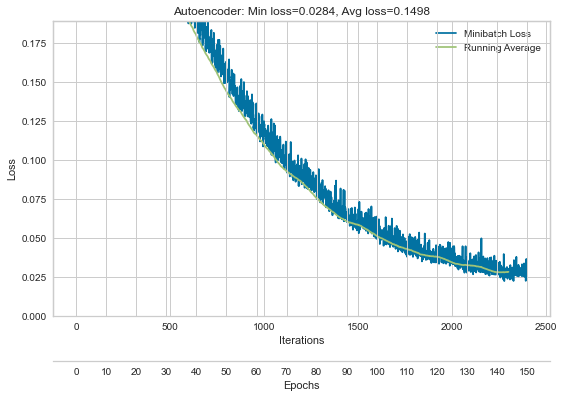

In [29]:
u.plot_training_loss(log_dict['train_loss_per_batch'], epochs)
plt.title("Autoencoder: Min loss={:.4f}, Avg loss={:.4f}".format(log_dict['final_loss'], log_dict['avg_loss']))
plt.savefig(PATH+"SECOND_ITERATION/seed="+str(seed)+"/autoencoder", dpi=300, bbox_inches='tight')
plt.show()

In [30]:
torch.save(model.state_dict(), PATH+"SECOND_ITERATION/models/XENA_LUNG_GeneExp_Autoencoder.kd")

---
---
---


## Compute pearson correlation b/w True_Dataset and Generated_Dataset

In [31]:
pearson_loader = DataLoader(train_dataset, len(train_dataset), shuffle=True)
pearson_correlation_coeff = u.pearson_correlation(model, pearson_loader, device)
with open(r'D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/SECOND_ITERATION/seed=%s/pearson.txt'%str(seed), 'w') as fp:
    fp.write("%s\n" % pearson_correlation_coeff)
print("Pearson Correlation Coefficient = ", pearson_correlation_coeff)

Pearson Correlation Coefficient =  0.9930949313450451


# Level 1 complete !!